In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

Load Data

In [43]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DT-Credit.csv')

In [44]:
df.head()

,Income,Limit,Rating,Cards,Age,Education,Own,Student,Married,Region,Balance
0,14.891,3606,283,2,34,11,No,No,Yes,South,333
1,106.025,6645,483,3,82,15,Yes,Yes,Yes,West,903
2,104.593,7075,514,4,71,11,No,No,No,West,580
3,148.924,9504,681,3,36,11,Yes,No,No,West,964
4,55.882,4897,357,2,68,16,No,No,Yes,South,331


In [45]:
df.shape

(400, 11)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Income     400 non-null    float64
 1   Limit      400 non-null    int64  
 2   Rating     400 non-null    int64  
 3   Cards      400 non-null    int64  
 4   Age        400 non-null    int64  
 5   Education  400 non-null    int64  
 6   Own        400 non-null    object 
 7   Student    400 non-null    object 
 8   Married    400 non-null    object 
 9   Region     400 non-null    object 
 10  Balance    400 non-null    int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 34.5+ KB


In [47]:
df.describe()

,Income,Limit,Rating,Cards,Age,Education,Balance
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,45.218885,4735.600000,354.940000,2.957500,55.667500,13.450000,520.015000
std,35.244273,2308.198848,154.724143,1.371275,17.249807,3.125207,459.758877
min,10.354000,855.000000,93.000000,1.000000,23.000000,5.000000,0.000000
25%,21.007250,3088.000000,247.250000,2.000000,41.750000,11.000000,68.750000
50%,33.115500,4622.500000,344.000000,3.000000,56.000000,14.000000,459.500000
75%,57.470750,5872.750000,437.250000,4.000000,70.000000,16.000000,863.000000
max,186.634000,13913.000000,982.000000,9.000000,98.000000,20.000000,1999.000000


In [48]:
df.isnull().sum()

,0
Income,0
Limit,0
Rating,0
Cards,0
Age,0
Education,0
Own,0
Student,0
Married,0
Region,0


Separate categorical and numerical columns

In [49]:
un = df['Own'].unique()
print(un)

['No' 'Yes']


In [50]:
un = df['Student'].unique()
print(un)

['No' 'Yes']


In [51]:
un = df['Region'].unique()
print(un)

['South' 'West' 'East']


In [52]:
un = df['Married'].unique()
print(un)

['Yes' 'No']


In [53]:
categorical = df.select_dtypes(include=['object']).columns
numerical = df.select_dtypes(exclude=['object']).columns


One-hot encode for categorical features

In [54]:
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_data = encoder.fit_transform(df[categorical])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical))
encoded_df.index = df.index


In [55]:
df = df.drop(categorical, axis=1)
df = pd.concat([df, encoded_df], axis=1)


In [56]:
X = df.drop(columns=['Balance'])
y = df['Balance']

In [57]:
X.head()

,Income,Limit,Rating,Cards,Age,Education,Own_Yes,Student_Yes,Married_Yes,Region_South,Region_West
0,14.891,3606,283,2,34,11,0.0,0.0,1.0,1.0,0.0
1,106.025,6645,483,3,82,15,1.0,1.0,1.0,0.0,1.0
2,104.593,7075,514,4,71,11,0.0,0.0,0.0,0.0,1.0
3,148.924,9504,681,3,36,11,1.0,0.0,0.0,0.0,1.0
4,55.882,4897,357,2,68,16,0.0,0.0,1.0,1.0,0.0


In [58]:
X.shape

(400, 11)

In [59]:
corr = df.corr()

target = corr['Balance'].sort_values(ascending=False)

print("Correlation of each feature with the target variable (Balance):")
print(target)

Correlation of each feature with the target variable (Balance):
Balance         1.000000
Rating          0.863625
Limit           0.861697
Income          0.463656
Student_Yes     0.259018
Cards           0.086456
Own_Yes         0.021474
Age             0.001835
Region_South   -0.003288
Married_Yes    -0.005673
Education      -0.008062
Region_West    -0.009812
Name: Balance, dtype: float64


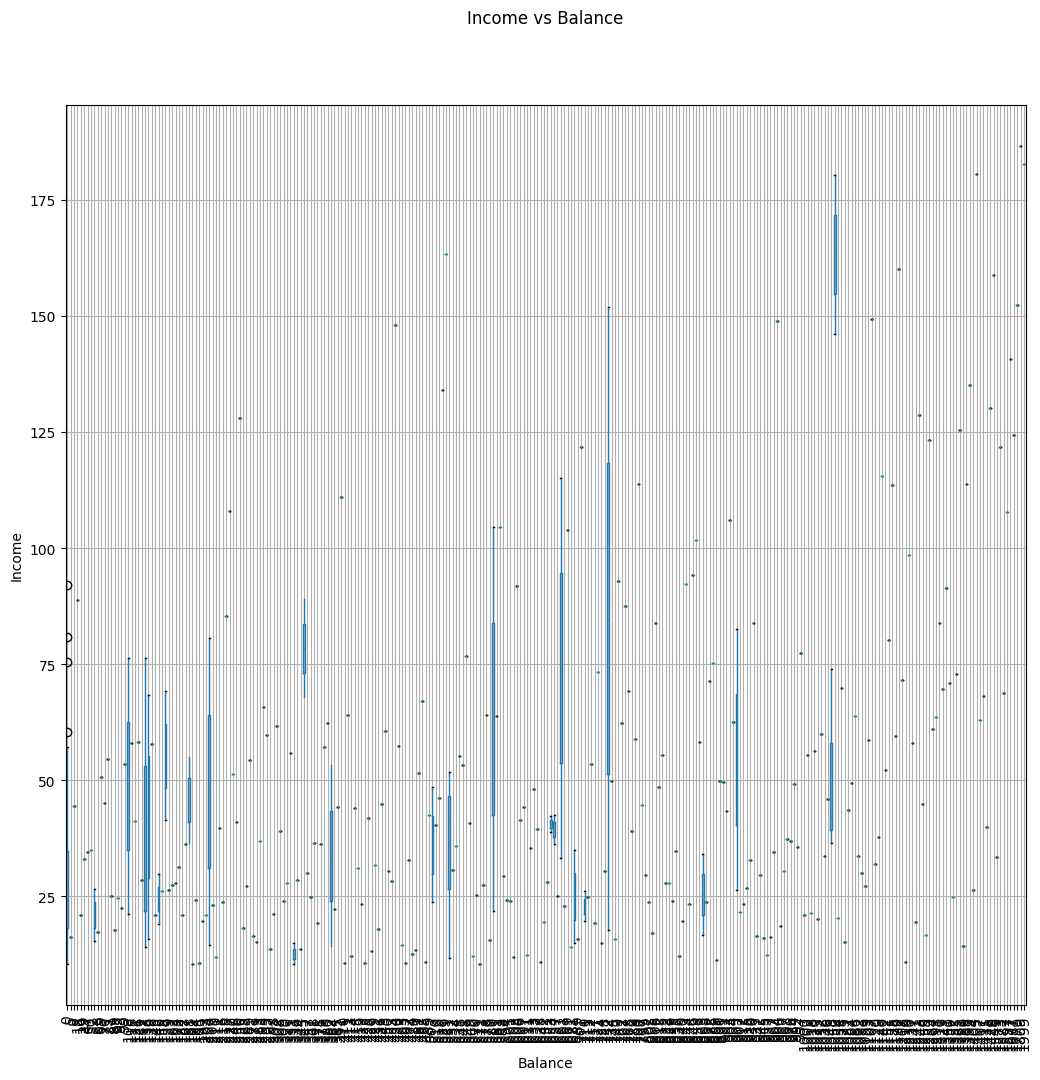

In [60]:
fig, ax = plt.subplots(1,1, figsize=(12, 12))
df.boxplot('Income', 'Balance', ax=ax)
plt.suptitle('Income vs Balance')
plt.title('')
plt.ylabel('Income')
plt.xticks(rotation=90)
plt.show()

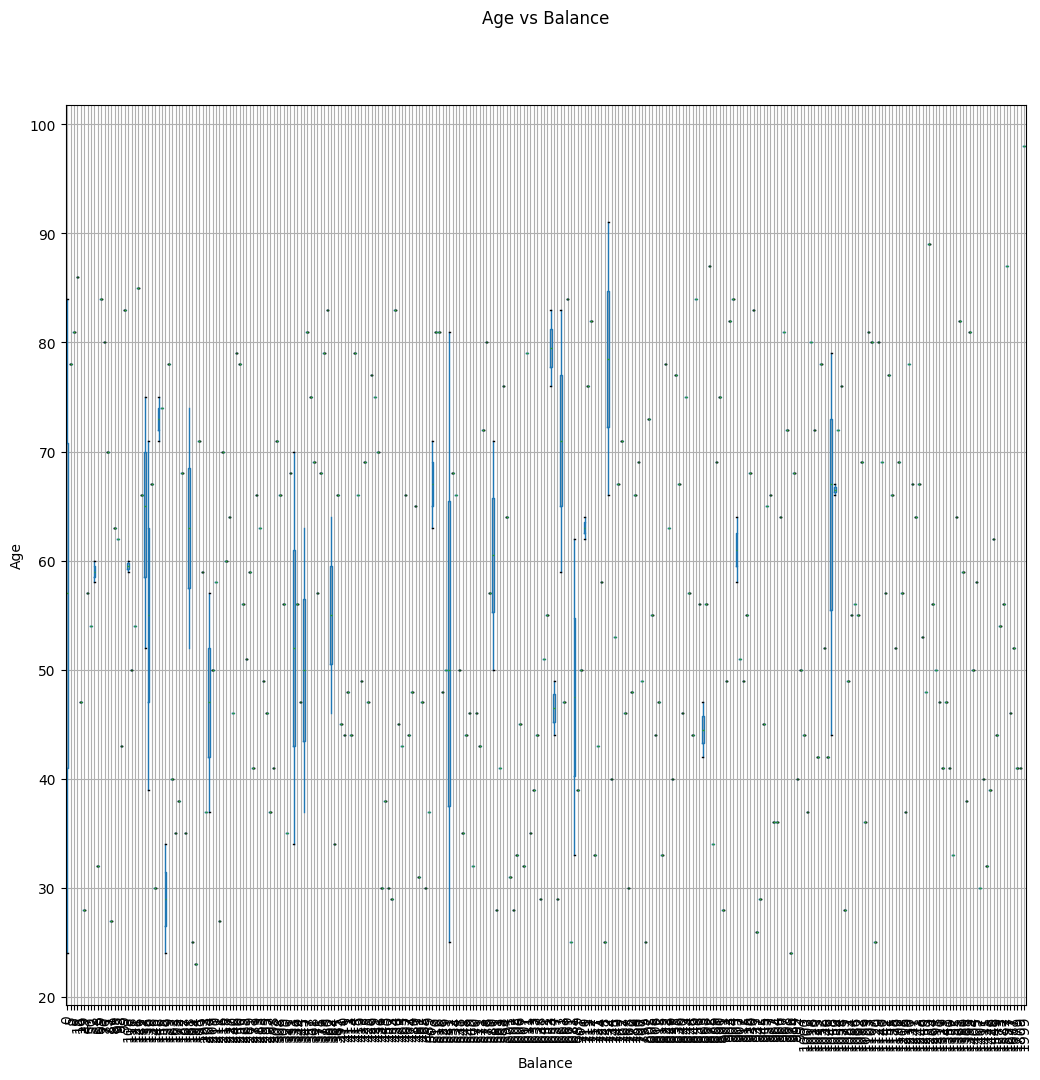

In [61]:
fig, ax = plt.subplots(1,1, figsize=(12, 12))
df.boxplot('Age', 'Balance', ax=ax)
plt.suptitle('Age vs Balance')
plt.title('')
plt.ylabel('Age')
plt.xticks(rotation=90)
plt.show()

Standardize features

In [62]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Split data: 70% train, 15% validate, 15% test

In [63]:
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [64]:
X_train.shape

(280, 11)

In [65]:
X_val.shape

(60, 11)

In [66]:
X_test.shape

(60, 11)

## Support vector regression (SVR)


In [67]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

In [68]:
param_grid = {
    'C': [0.1, 1, 10, 100,200,300,500,1500,2000],
    'epsilon': [0.01, 0.1, 0.2,0.25,0.3],
    'gamma': ['scale', 'auto']
}


In [69]:
svr = SVR(kernel='rbf')

grid_search = GridSearchCV(estimator=svr, param_grid=param_grid,
                           cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 200, 300, 500, 1500, 2000],
                         'epsilon': [0.01, 0.1, 0.2, 0.25, 0.3],
                         'gamma': ['scale', 'auto']},
             scoring='neg_mean_squared_error')

In [70]:
best_params = grid_search.best_params_
print("Best hyperparameters found by GridSearchCV:")
print(best_params)

Best hyperparameters found by GridSearchCV:
{'C': 2000, 'epsilon': 0.01, 'gamma': 'auto'}


In [71]:
best_svr = grid_search.best_estimator_

In [72]:
y_pred_train = best_svr.predict(X_train)
y_pred_val = best_svr.predict(X_val)
y_pred_test = best_svr.predict(X_test)

In [73]:
def custom_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def custom_r2(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    return 1 - (ss_residual / ss_total)

In [74]:
mse_train = custom_mse(y_train, y_pred_train)
mse_val = custom_mse(y_val, y_pred_val)
mse_test = custom_mse(y_test, y_pred_test)

r2_train = custom_r2(y_train, y_pred_train)
r2_val = custom_r2(y_val, y_pred_val)
r2_test = custom_r2(y_test, y_pred_test)

print("SVR Model with GridSearchCV Evaluation:")
print(f"Training MSE: {mse_train}")
print(f"Validation MSE: {mse_val}")
print(f"Test MSE: {mse_test}")
print(f"Training R²: {r2_train}")
print(f"Validation R²: {r2_val}")
print(f"Test R²: {r2_test}")


SVR Model with GridSearchCV Evaluation:
Training MSE: 163.39468422381557
Validation MSE: 9091.268315384084
Test MSE: 7715.051842473371
Training R²: 0.9992610616109442
Validation R²: 0.9589441408223247
Test R²: 0.9482398227404857


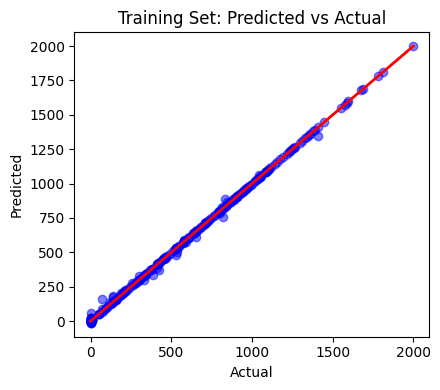

In [75]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.scatter(y_train, y_pred_train, color='blue', alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', lw=2)
plt.title('Training Set: Predicted vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.tight_layout()
plt.show()

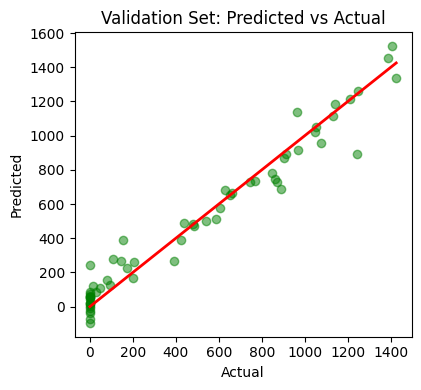

In [76]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 2)
plt.scatter(y_val, y_pred_val, color='green', alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', lw=2)
plt.title('Validation Set: Predicted vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.tight_layout()
plt.show()


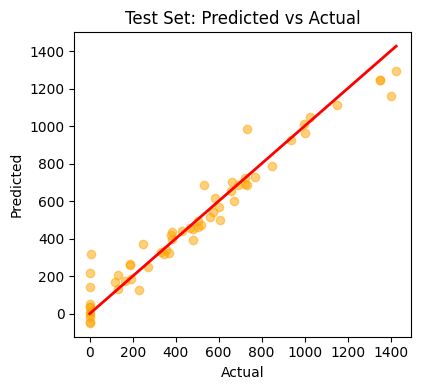

In [77]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_pred_test, color='orange', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.title('Test Set: Predicted vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.tight_layout()
plt.show()

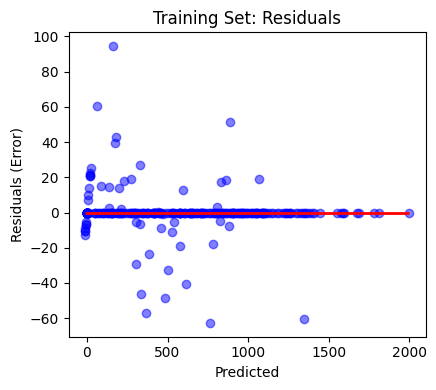

In [78]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.scatter(y_pred_train, y_pred_train - y_train, color='blue', alpha=0.5)
plt.hlines(y=0, xmin=y_pred_train.min(), xmax=y_pred_train.max(), color='red', lw=2)
plt.title('Training Set: Residuals')
plt.xlabel('Predicted')
plt.ylabel('Residuals (Error)')

plt.tight_layout()
plt.show()


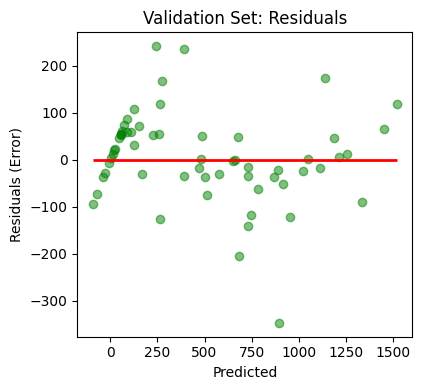

In [79]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 2)
plt.scatter(y_pred_val, y_pred_val - y_val, color='green', alpha=0.5)
plt.hlines(y=0, xmin=y_pred_val.min(), xmax=y_pred_val.max(), color='red', lw=2)
plt.title('Validation Set: Residuals')
plt.xlabel('Predicted')
plt.ylabel('Residuals (Error)')

plt.tight_layout()
plt.show()

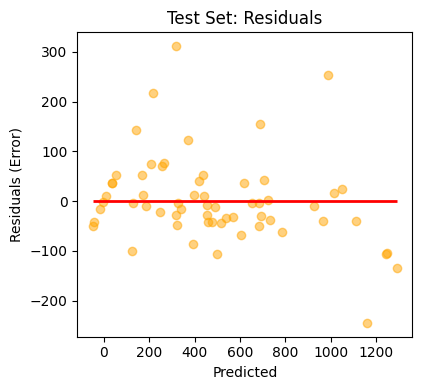

In [80]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 3)
plt.scatter(y_pred_test, y_pred_test - y_test, color='orange', alpha=0.5)
plt.hlines(y=0, xmin=y_pred_test.min(), xmax=y_pred_test.max(), color='red', lw=2)
plt.title('Test Set: Residuals')
plt.xlabel('Predicted')
plt.ylabel('Residuals (Error)')

plt.tight_layout()
plt.show()